In [ ]:
!pip install transformers
!pip install datasets
!pip install contractions
!pip install scikit-multilearn

https://neptune.ai/blog/deploy-nlp-models-in-production

https://neptune.ai/blog/mlops-pipeline-for-nlp-machine-translation

https://medium.com/@Abhiney27/configure-ci-cd-to-deploy-flask-app-on-docker-container-with-jenkins-ae350b306c6b

https://ruslanmv.com/blog/How-to-handle-imbalanced-text-data-in-Natural-Language-Processing

https://medium.com/saarthi-ai/deploying-a-machine-learning-model-using-django-part-1-6c7de05c8d7

In [ ]:
import pandas as pd
import numpy as np
import mlflow
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('english')
import re
import contractions

# for model data loading, training and testing
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torchtext
device='cuda'
import warnings 
warnings.filterwarnings("ignore")
torch.manual_seed(42)

# for loading dataset from hugging face
import datasets
from datasets import load_dataset,concatenate_datasets

# for loading tokenizers and pretrained models
from transformers import BertTokenizer,AutoTokenizer,BertModel, AdamW,RobertaTokenizer,RobertaModel

#visualtization libraries
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

#classification libraries
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.problem_transform import LabelPowerset,BinaryRelevance,ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import GaussianNB,MultinomialNB

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
mlflow.autolog()

2023/05/23 14:26:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/05/23 14:26:28 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of transformers. If you encounter errors during autologging, try upgrading / downgrading transformers to a supported version, or try upgrading MLflow.
2023/05/23 14:26:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2023/05/23 14:26:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/05/23 14:26:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


In [ ]:
train_dataset=load_dataset("go_emotions",split="train")
valid_dataset=load_dataset("go_emotions",split='validation')
test_dataset=load_dataset("go_emotions",split="test")

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


In [ ]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'labels': Sequence(feature=ClassLabel(names=['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'], id=None), length=-1, id=None),
 'id': Value(dtype='string', id=None)}

In [ ]:
train_dataset=train_dataset.remove_columns('id')
valid_dataset=valid_dataset.remove_columns('id')
test_dataset=test_dataset.remove_columns('id')

In [ ]:
tv_dataset=concatenate_datasets([train_dataset,valid_dataset])

In [ ]:
df_tv=pd.DataFrame(tv_dataset)
df_train=pd.DataFrame(train_dataset)
df_valid=pd.DataFrame(valid_dataset)
df_test=pd.DataFrame(test_dataset)

In [ ]:
df_tv.isna().sum().sum()

0

In [ ]:
dftv1=df_tv.copy()
dftrain1=df_train.copy()
dfvalid1=df_test.copy()
dftest1=df_test.copy()

In [ ]:
dftest1.head(10)

,text,labels
0,I’m really sorry about your situation :( Altho...,[25]
1,It's wonderful because it's awful. At not with.,[0]
2,"Kings fan here, good luck to you guys! Will be...",[13]
3,"I didn't know that, thank you for teaching me ...",[15]
4,They got bored from haunting earth for thousan...,[27]
5,Thank you for asking questions and recognizing...,[15]
6,You’re welcome,[15]
7,100%! Congrats on your job too!,[15]
8,I’m sorry to hear that friend :(. It’s for the...,[24]
9,"Girlfriend weak as well, that jump was pathetic.",[25]


i) Admiration (0) + Approval(4), 
ii) Surprise(26), 
iii) Anger(2) + Annoyance(3)+disgust(11)+disapproval(10) -- negative emotions,
iv) Confusion (6), 
v) Sadness(25) (Disappointment (9)),
vi) Fear(14) + Nervousness(19),
vii) Amusement(1) + Excitement(13) + Joy(17),
viii) Desire(8) + Curiosity(7),
ix) Love(18) + Caring(5), 
x)  Grief(16) + Remorse(24) + realization(22) + Relief(23), 
xi) optimism (20) + pride (21), 
xii) Gratitude(15), 
xiii) Embarrassment(12) , 
xiv) Neutral,

In [ ]:
dfvisualize=pd.concat([df_tv,df_test],axis=0,ignore_index=True)

In [ ]:
dfvisualize1=dfvisualize.copy()

In [ ]:
labels = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", 
          "confusion", "curiosity", "desire", "disappointment", "disapproval",
          "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief",
          "joy", "love", "nervousness", "optimism", "pride", "realization",
          "relief", "remorse", "sadness", "surprise", "neutral"]

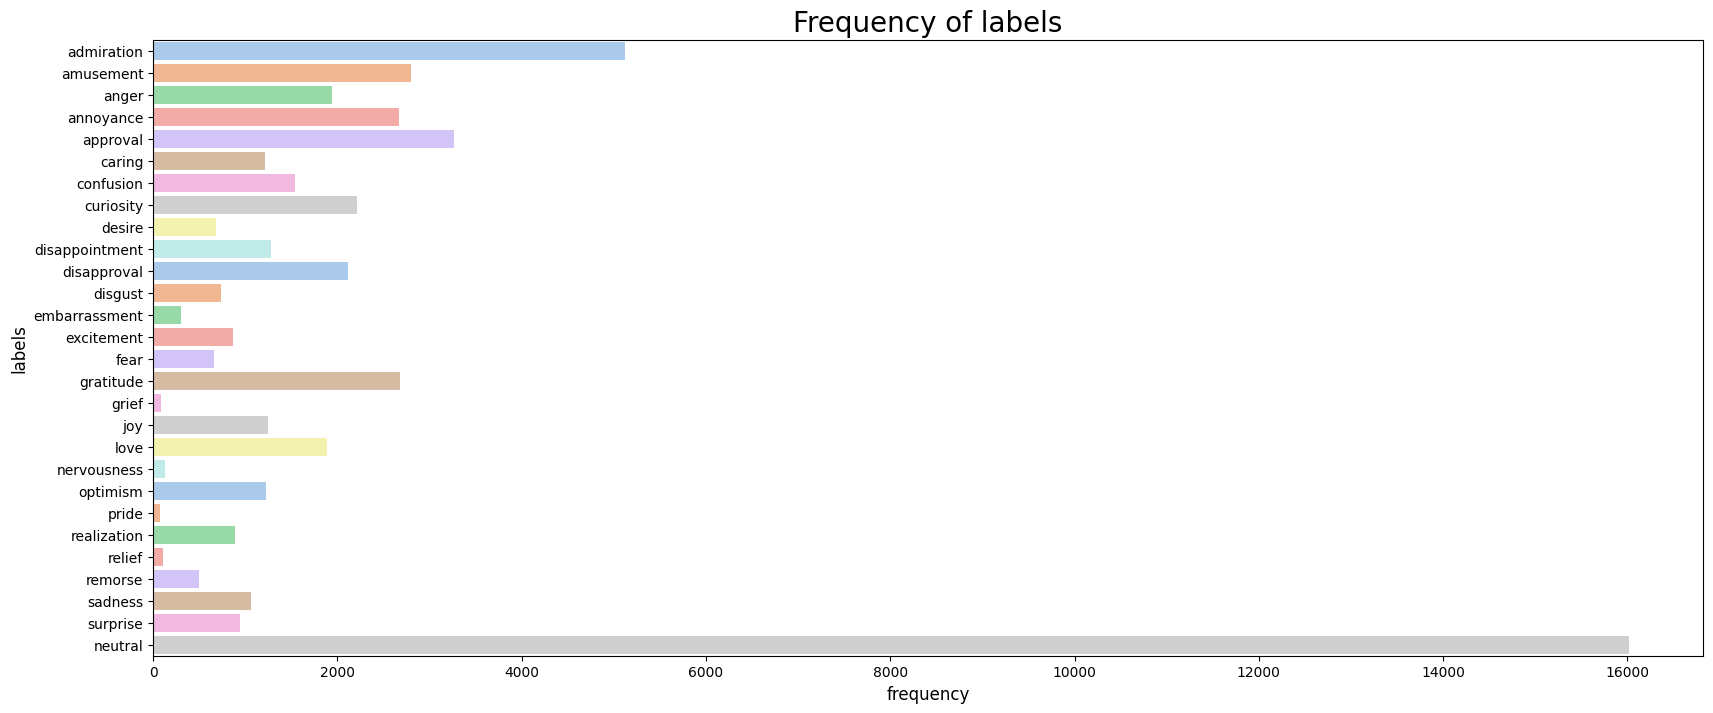

In [ ]:
dfvisualize['fltnlabels'] = dfvisualize['labels'].apply(lambda x: x[0]) #flattening the lists present in the labels column
labelcnt=(dfvisualize['fltnlabels'].value_counts())
labelcnt.sort_index(inplace=True)
labelcnt.index = labelcnt.index.astype('category')

plt.figure(figsize=(20, 8))
sns.barplot(x=labelcnt.values, y=labels, palette='pastel')
plt.xlabel("frequency", size=12)
plt.ylabel("labels", size=12)
plt.title("Frequency of labels", size=20)
plt.show()

In [ ]:
new_labels={0:[0,4],1:[26],2:[2,3,11,10],3:[6],4:[25,9],5:[14,19],6:[1,13,17],7:[8,7],8:[18,5],9:[16,24,22,23],10:[20,21],11:[15],12:[12],13:[27]}

In [ ]:
def getlabel(label):
  keys = []
  for k, v in (new_labels.items()):
    if label in v:
      keys.append(k)
  return keys if keys else "Value not found"


dftv1['labels']=dftv1['labels'].apply(lambda i: [j for key in i for j in getlabel(key)])

In [ ]:
dftrain1['labels']=dftrain1['labels'].apply(lambda i: [j for key in i for j in getlabel(key)])

In [ ]:
dfvalid1['labels']=dfvalid1['labels'].apply(lambda i: [j for key in i for j in getlabel(key)])

In [ ]:
dftest1['labels']=df_test['labels'].apply(lambda i: [j for key in i for j in getlabel(key)])

In [ ]:
dftv1['labels'].head(10)

0       [13]
1       [13]
2        [2]
3        [5]
4        [2]
5        [1]
6       [11]
7    [7, 10]
8        [0]
9       [13]
Name: labels, dtype: object

In [ ]:
dfvisualize1['labels']=dfvisualize1['labels'].apply(lambda i: [j for key in i for j in getlabel(key)])

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
onehotencoding=MultiLabelBinarizer()
ohl_tv=onehotencoding.fit_transform(dftv1['labels'])
ohl_train=onehotencoding.fit_transform(dftrain1['labels'])
ohl_valid=onehotencoding.fit_transform(dfvalid1['labels'])
ohl_test=onehotencoding.fit_transform(dftest1['labels'])
ohl_train

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
ohl_tv.shape

(48836, 14)

In [ ]:
newlabelnames=['appreciation', 'surprise','negative','confusion','sadness','fear','happy','desire','affection','distress','confidence','gratitude','embarrassment','neutral']

In [ ]:
dfvisualize1['fltnlabels'] = dfvisualize1['labels'].apply(lambda x: x[0]) #flattening the lists present in the labels column
labelcnt=dfvisualize1['fltnlabels'].value_counts()
labelcnt.sort_index(inplace=True)
labelcnt.index = labelcnt.index.astype('category')

plt.figure(figsize=(20, 8))
sns.barplot(x=labelcnt.values, y=newlabelnames, palette='pastel')
plt.xlabel("frequency", size=12)
plt.ylabel("labels", size=12)
plt.title("Frequency of labels", size=20)
plt.show()

In [ ]:
tvlabeldf=pd.DataFrame(ohl_tv,columns=newlabelnames)
trainlabeldf=pd.DataFrame(ohl_train,columns=newlabelnames)
validlabeldf=pd.DataFrame(ohl_valid,columns=newlabelnames)
testlabeldf=pd.DataFrame(ohl_test,columns=newlabelnames)

In [ ]:
mapped_dftv=pd.concat([dftv1,tvlabeldf],axis=1)
mapped_dftrain=pd.concat([dftrain1,trainlabeldf],axis=1)
mapped_dfvalid=pd.concat([dfvalid1,validlabeldf],axis=1)
mapped_dftest=pd.concat([dftest1,testlabeldf],axis=1)
mapped_dftv.tail(5)

,text,labels,appreciation,surprise,negative,confusion,sadness,fear,happy,desire,affection,distress,confidence,gratitude,embarrassment,neutral
48831,It's pretty dangerous when the state decides w...,[5],0,0,0,0,0,1,0,0,0,0,0,0,0,0
48832,I filed for divorce this morning. Hoping he mo...,[10],0,0,0,0,0,0,0,0,0,0,1,0,0,0
48833,"The last time it happened I just said, ""No"" an...",[2],0,0,1,0,0,0,0,0,0,0,0,0,0,0
48834,I can’t stand this arrogant prick he’s no bett...,[2],0,0,1,0,0,0,0,0,0,0,0,0,0,0
48835,::but I like baby bangs:: /tiny voice,[8],0,0,0,0,0,0,0,0,1,0,0,0,0,0


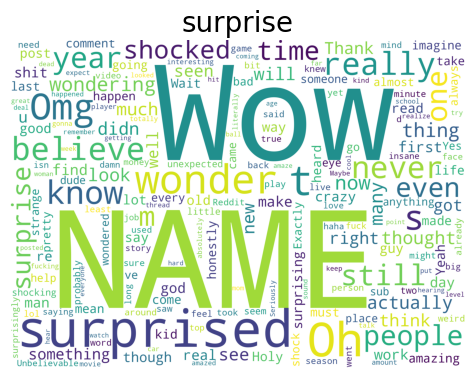

In [ ]:
plt.figure(figsize=(20,15))

onelabel = mapped_dftv[mapped_dftv.surprise==1]
text = onelabel.text.values
surprisefig = WordCloud(stopwords=STOPWORDS,collocations=False,background_color='white',width=2500,height=1800).generate(" ".join(text))

plt.subplot(2, 3, 1)
plt.axis('off')
plt.title("surprise",fontsize=20)
plt.imshow(surprisefig)

### > **As you can see in the above figure the word "name" has more frequency than other words which is not a relevant word to the label, it appears in the other labels with high frequency as well so here the word is removed.**

# Normalisation

### Lowering the text

In [ ]:
mapped_dftv['normalised_text']=mapped_dftv['text'].apply(lambda x: x.lower())
mapped_dftrain['normalised_text']=mapped_dftrain['text'].apply(lambda x: x.lower())
mapped_dfvalid['normalised_text']=mapped_dfvalid['text'].apply(lambda x: x.lower())
mapped_dftest['normalised_text']=mapped_dftest['text'].apply(lambda x: x.lower())

### Replacing Contractions

In [ ]:
mapped_dftv['normalised_text']=mapped_dftv['normalised_text'].apply(lambda t: contractions.fix(t))
mapped_dftrain['normalised_text']=mapped_dftrain['normalised_text'].apply(lambda t: contractions.fix(t))
mapped_dfvalid['normalised_text']=mapped_dfvalid['normalised_text'].apply(lambda t: contractions.fix(t))
mapped_dftest['normalised_text']=mapped_dftest['normalised_text'].apply(lambda t: contractions.fix(t))

### Punctuation Removal

In [ ]:
mapped_dftv['normalised_text']=mapped_dftv['normalised_text'].str.replace("[^a-zA-Z0-9'#]", " ")
mapped_dftrain['normalised_text']=mapped_dftrain['normalised_text'].str.replace("[^a-zA-Z0-9'#]", " ")
mapped_dfvalid['normalised_text']=mapped_dfvalid['normalised_text'].str.replace("[^a-zA-Z0-9'#]", " ")
mapped_dftest['normalised_text']=mapped_dftest['normalised_text'].str.replace("[^a-zA-Z0-9'#]"," ")

In [ ]:
#removing the word name from the normalised text
mapped_dftv['normalised_text']=mapped_dftv['normalised_text'].str.replace("name", "")
mapped_dftrain['normalised_text']=mapped_dftrain['normalised_text'].str.replace("name", "")
mapped_dfvalid['normalised_text']=mapped_dfvalid['normalised_text'].str.replace("name", "")
mapped_dftest['normalised_text']=mapped_dftest['normalised_text'].str.replace("name","")

In [ ]:
mapped_dftv['normalised_text'].head(10)

0    my favourite food is anything i did not have t...
1    now if he does off himself  everyone will thin...
2                       why the fuck is bayless isoing
3                          to make her feel threatened
4                               dirty southern wankers
5    omg peyton is not good enough to help us in th...
6    yes i heard about the f bombs  that has to be ...
7    we need more boards and to create a bit more s...
8    damn youtube and outrage drama is super lucrat...
9    it might be linked to the trust factor of your...
Name: normalised_text, dtype: object

## Visualization

In [ ]:
plt.figure(figsize=(30,18))
#appreciation
onelabel = mapped_dftv[mapped_dftv.appreciation==1]
text = onelabel.normalised_text.values
appreciationfig = WordCloud(stopwords=STOPWORDS,collocations=False,background_color='white',width=3000,height=2000).generate(" ".join(text))
plt.subplot(5, 3, 1)
plt.axis('off')
plt.title("appreciation",fontsize=20)
plt.imshow(appreciationfig)

#surprise
onelabel = mapped_dftv[mapped_dftv.surprise==1]
text = onelabel.normalised_text.values
surprisefig = WordCloud(stopwords=STOPWORDS,collocations=False,background_color='white',width=3000,height=2000).generate(" ".join(text))
plt.subplot(5, 3, 2)
plt.axis('off')
plt.title("surprise",fontsize=20)
plt.imshow(surprisefig)

#negative
onelabel = mapped_dftv[mapped_dftv.negative==1]
text = onelabel.normalised_text.values
negativefig = WordCloud(stopwords=STOPWORDS,collocations=False,background_color='white',width=3000,height=2000).generate(" ".join(text))
plt.subplot(5, 3, 3)
plt.axis('off')
plt.title("negative",fontsize=20)
plt.imshow(negativefig)

#confusion
onelabel = mapped_dftv[mapped_dftv.confusion==1]
text = onelabel.normalised_text.values
confusionfig = WordCloud(stopwords=STOPWORDS,collocations=False,background_color='white',width=3000,height=2000).generate(" ".join(text))
plt.subplot(5, 3, 4)
plt.axis('off')
plt.title("confusion",fontsize=20)
plt.imshow(confusionfig)

#sadness
onelabel = mapped_dftv[mapped_dftv.confusion==1]
text = onelabel.normalised_text.values
sadnessfig = WordCloud(stopwords=STOPWORDS,collocations=False,background_color='white',width=3000,height=2000).generate(" ".join(text))
plt.subplot(5, 3, 5)
plt.axis('off')
plt.title("sadness",fontsize=20)
plt.imshow(sadnessfig)

#fear
onelabel = mapped_dftv[mapped_dftv.fear==1]
text = onelabel.normalised_text.values
fearfig = WordCloud(stopwords=STOPWORDS,collocations=False,background_color='white',width=3000,height=2000).generate(" ".join(text))
plt.subplot(5, 3, 6)
plt.axis('off')
plt.title("fear",fontsize=20)
plt.imshow(fearfig)

#happy
onelabel = mapped_dftv[mapped_dftv.happy==1]
text = onelabel.normalised_text.values
happyfig = WordCloud(stopwords=STOPWORDS,collocations=False,background_color='white',width=3000,height=2000).generate(" ".join(text))
plt.subplot(5, 3, 7)
plt.axis('off')
plt.title("happy",fontsize=20)
plt.imshow(happyfig)

#desire
onelabel = mapped_dftv[mapped_dftv.desire==1]
text = onelabel.normalised_text.values
desirefig = WordCloud(stopwords=STOPWORDS,collocations=False,background_color='white',width=3000,height=2000).generate(" ".join(text))
plt.subplot(5, 3, 8)
plt.axis('off')
plt.title("desire",fontsize=20)
plt.imshow(desirefig)

#affection
onelabel = mapped_dftv[mapped_dftv.affection==1]
text = onelabel.normalised_text.values
affectionfig = WordCloud(stopwords=STOPWORDS,collocations=False,background_color='white',width=3000,height=2000).generate(" ".join(text))
plt.subplot(5, 3, 9)
plt.axis('off')
plt.title("affection",fontsize=20)
plt.imshow(affectionfig)

#distress
onelabel = mapped_dftv[mapped_dftv.distress==1]
text = onelabel.normalised_text.values
distressfig = WordCloud(stopwords=STOPWORDS,collocations=False,background_color='white',width=3000,height=2000).generate(" ".join(text))
plt.subplot(5, 3, 10)
plt.axis('off')
plt.title("distress",fontsize=20)
plt.imshow(distressfig)

#confidence
onelabel = mapped_dftv[mapped_dftv.confidence==1]
text = onelabel.normalised_text.values
confidencefig = WordCloud(stopwords=STOPWORDS,collocations=False,background_color='white',width=3000,height=2000).generate(" ".join(text))
plt.subplot(5, 3, 11)
plt.axis('off')
plt.title("confidence",fontsize=20)
plt.imshow(confidencefig)

#gratitude
onelabel = mapped_dftv[mapped_dftv.gratitude==1]
text = onelabel.normalised_text.values
gratitudefig = WordCloud(stopwords=STOPWORDS,collocations=False,background_color='white',width=3000,height=2000).generate(" ".join(text))
plt.subplot(5, 3, 12)
plt.axis('off')
plt.title("gratitude",fontsize=20)
plt.imshow(gratitudefig)

#embarrassment
onelabel = mapped_dftv[mapped_dftv.embarrassment==1]
text = onelabel.normalised_text.values
embarrassmentfig = WordCloud(stopwords=STOPWORDS,collocations=False,background_color='white',width=3000,height=2000).generate(" ".join(text))
plt.subplot(5, 3, 13)
plt.axis('off')
plt.title("embarrassment",fontsize=20)
plt.imshow(embarrassmentfig)

#neutral
onelabel = mapped_dftv[mapped_dftv.neutral==1]
text = onelabel.normalised_text.values
neutralfig = WordCloud(stopwords=STOPWORDS,collocations=False,background_color='white',width=3000,height=2000).generate(" ".join(text))
plt.subplot(5, 3, 14)
plt.axis('off')
plt.title("neutral",fontsize=20)
plt.imshow(neutralfig)

plt.show()

#### > **Now the word "name" is removed and the words are varied from large to small according to their frequencies. The high frequency words are with large appearence.**

## Vectorization and Classifier

In [ ]:
train_labels,test_labels=ohl_tv,ohl_test
train_labels.shape

(48836, 14)

In [ ]:
tfidf = TfidfVectorizer(analyzer='word',max_features=20,stop_words='english')
trainfeatures=tfidf.fit_transform(mapped_dftv['normalised_text'])
testfeatures=tfidf.fit_transform(mapped_dftest['normalised_text'])
clf=LabelPowerset(MultinomialNB())
clf.fit(trainfeatures,train_labels)
pred = clf.predict(testfeatures)
print("Accuracy = {:.2f}".format(metrics.accuracy_score(test_labels,pred)*100))

In [ ]:
print(classification_report(test_labels,pred))

              precision    recall  f1-score   support

           0       0.11      0.01      0.02       834
           1       0.00      0.00      0.00       141
           2       0.00      0.00      0.00       822
           3       0.00      0.00      0.00       153
           4       0.00      0.00      0.00       290
           5       0.00      0.00      0.00        98
           6       0.07      0.03      0.04       510
           7       0.00      0.00      0.00       363
           8       0.07      0.01      0.02       366
           9       0.03      0.00      0.01       218
          10       0.03      0.02      0.03       201
          11       0.97      0.82      0.89       352
          12       0.00      0.00      0.00        37
          13       0.30      0.29      0.30      1787

   micro avg       0.33      0.14      0.19      6172
   macro avg       0.11      0.09      0.09      6172
weighted avg       0.17      0.14      0.14      6172
 samples avg       0.16   

In [ ]:
pred=pred.toarray()

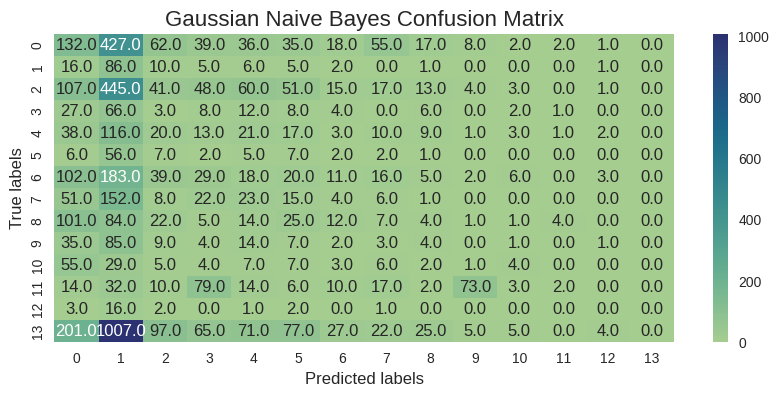

In [ ]:
plt.figure(figsize=(12, 6))
cm = confusion_matrix(np.asarray(test_labels).argmax(axis=1), np.asarray(pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='.1f', cmap='crest')
plt.xlabel("Predicted labels", size=12)
plt.ylabel("True labels", size=12)
plt.title("Gaussian Naive Bayes Confusion Matrix", size=16)
plt.show()

# Tokenization

In [ ]:
berttokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
robertatokenizer=RobertaTokenizer.from_pretrained("roberta-base")

In [ ]:
#here the tokenization and the dataset for the pytorch loader to load is being prepared
class Tokenization(Dataset):
  def __init__(self,df,tokenizer):
    self.df=df
    self.tokenizer=tokenizer
    self.labels=df[newlabelnames].values
  def __len__(self):
    return len(self.df)
  def __getitem__(self,index):
    text=self.df['normalised_text'].iloc[index]
    tokenized_dataset=self.tokenizer.encode_plus(text,max_length=30,truncation=True,return_token_type_ids=True,padding='max_length',return_tensors='pt')
    input_ids=tokenized_dataset['input_ids']
    attention_mask=tokenized_dataset['attention_mask']
    token_type_ids = tokenized_dataset["token_type_ids"]
    return {
        'input_ids': torch.tensor(input_ids.flatten(), dtype=torch.long),
        'attention_mask': torch.tensor(attention_mask.flatten(), dtype=torch.long),
        'token_type_ids': torch.tensor(token_type_ids.flatten(), dtype=torch.long),
        'labels': torch.FloatTensor(self.labels[index])
        }

# BERT

In [ ]:
class bertmodel(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = BertModel.from_pretrained("bert-base-uncased",return_dict=False)
    self.l2 = torch.nn.Dropout(0.3)
    self.classifier=nn.Linear(768,14)
  def forward(self,input_ids,attention_mask,token_type_ids):
    _,features = self.model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
    output=self.classifier(features)
    return output

bertmodel=bertmodel()
bertmodel.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bertmodel(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
berttv_dataset=Tokenization(mapped_dftv,berttokenizer)
berttrain_dataset=Tokenization(mapped_dftrain,berttokenizer)
bertvalid_dataset=Tokenization(mapped_dfvalid,berttokenizer)
berttest_dataset=Tokenization(mapped_dftest,berttokenizer)

In [ ]:
# a=berttrain_dataset[0]
# berttokenizer.convert_ids_to_tokens(a['input_ids']) #run this cell to see the input ids as string tokens

In [ ]:
batch_size=64

In [ ]:
berttv_dataloader=DataLoader(berttv_dataset,batch_size=batch_size,shuffle=True)
berttrain_dataloader=DataLoader(berttrain_dataset,batch_size=batch_size,shuffle=True)
bertvalid_dataloader=DataLoader(bertvalid_dataset,batch_size=batch_size,shuffle=False)
berttest_dataloader=DataLoader(berttest_dataset,batch_size=batch_size,shuffle=False)

# ROBERTA

In [ ]:
class robertamodel(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = RobertaModel.from_pretrained("roberta-base",return_dict=False)
    self.classifier=nn.Linear(768,14)
  def forward(self,input_ids,attention_mask,token_type_ids):
    _,features = self.model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
    output=self.classifier(features)
    return output

robertamodel=robertamodel()
robertamodel.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


robertamodel(
  (model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [ ]:
robertatv_dataset=Tokenization(mapped_dftv,robertatokenizer)
robertatrain_dataset=Tokenization(mapped_dftrain,robertatokenizer)
robertavalid_dataset=Tokenization(mapped_dfvalid,robertatokenizer)
robertatest_dataset=Tokenization(mapped_dftest,robertatokenizer)

In [ ]:
robertatv_dataloader=DataLoader(robertatv_dataset,batch_size=batch_size,shuffle=True)
robertatrain_dataloader=DataLoader(robertatrain_dataset,batch_size=batch_size,shuffle=True)
robertavalid_dataloader=DataLoader(robertavalid_dataset,batch_size=batch_size,shuffle=False)
robertatest_dataloader=DataLoader(robertatest_dataset,batch_size=batch_size,shuffle=False)

In [ ]:
lr=2e-5

In [ ]:
bertoptimizer = AdamW(params =bertmodel.parameters(), lr=2e-5)
robertaoptimizer = AdamW(params =robertamodel.parameters(), lr=2e-5)

In [ ]:
loss_fn=nn.MultiLabelSoftMarginLoss() #BCEWithLogitsLoss() 

In [ ]:
loss_list=[]
trainingacc=[]
model=bertmodel
train_dataloader,valid_dataloader,optimizer=berttrain_dataloader,bertvalid_dataloader,bertoptimizer
for epoch in range(6):
#def train(model,epoch,train_dataloader,valid_dataloader,optimizer):
    correct = 0
    model.train()
    for _,data in enumerate(train_dataloader,0):
        input_ids = data['input_ids'].to(device, dtype = torch.long)
        attention_mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['labels'].to(device, dtype = torch.float)
        outputs=model(input_ids,attention_mask,token_type_ids)
        loss=nn.MultiLabelSoftMarginLoss()(outputs, targets)           
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        correct += outputs.eq(targets).cpu().sum().item()
    print("Train ===> Epoch :",epoch,"Loss:",(loss.item()))

    model.eval()
    finaltargets=[]
    finaloutputs=[]
    with torch.no_grad():
      finaltargets.extend(targets.cpu().detach().numpy().tolist())
      finaloutputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    bertoutputs, berttargets = finaloutputs, finaltargets
    bertoutputs = np.array(bertoutputs) >= 0.5
    bertoutputs[bertoutputs >= 0.5]=1
    bertacc = round(metrics.accuracy_score(berttargets, bertoutputs),4)
    print("Accuracy:",(bertacc)*100)
    
    
def test(model,test_dataloader):
    model.eval()
    finaltargets=[]
    finaloutputs=[]
    with torch.no_grad():
        for _, data in enumerate(test_dataloader, 0):
            input_ids = data['input_ids'].to(device, dtype = torch.long)
            attention_mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['labels'].to(device, dtype = torch.float)
            outputs = model(input_ids, attention_mask, token_type_ids)
            finaltargets.extend(targets.cpu().detach().numpy().tolist())
            finaloutputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return finaloutputs, finaltargets
    

Train ===> Epoch : 0 Loss: 0.03831891342997551
Accuracy: 77.78
Train ===> Epoch : 1 Loss: 0.029740197584033012
Accuracy: 83.33
Train ===> Epoch : 2 Loss: 0.07863152772188187
Accuracy: 66.67
Train ===> Epoch : 3 Loss: 0.011723299510776997
Accuracy: 100.0
Train ===> Epoch : 4 Loss: 0.04162045568227768
Accuracy: 77.78
Train ===> Epoch : 5 Loss: 0.03698275610804558
Accuracy: 83.33


In [ ]:
print("learning rate:",lr,"Batch size:",batch_size, "Loss function:",loss_fn)
for epoch in range(10):
  train(bertmodel,epoch,berttrain_dataloader,bertvalid_dataloader,bertoptimizer)

In [ ]:
bertoutputs, berttargets = test(bertmodel,berttest_dataloader)
bertoutputs = np.array(bertoutputs) >= 0.5
bertoutputs[bertoutputs >= 0.5]=1
bertacc = metrics.accuracy_score(berttargets, bertoutputs)
print("Accuracy:",(bertacc)*100)

Accuracy: 49.732817394508935


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
torch.save(model.state_dict(),'goemotions_model1.pt')

NameError: ignored

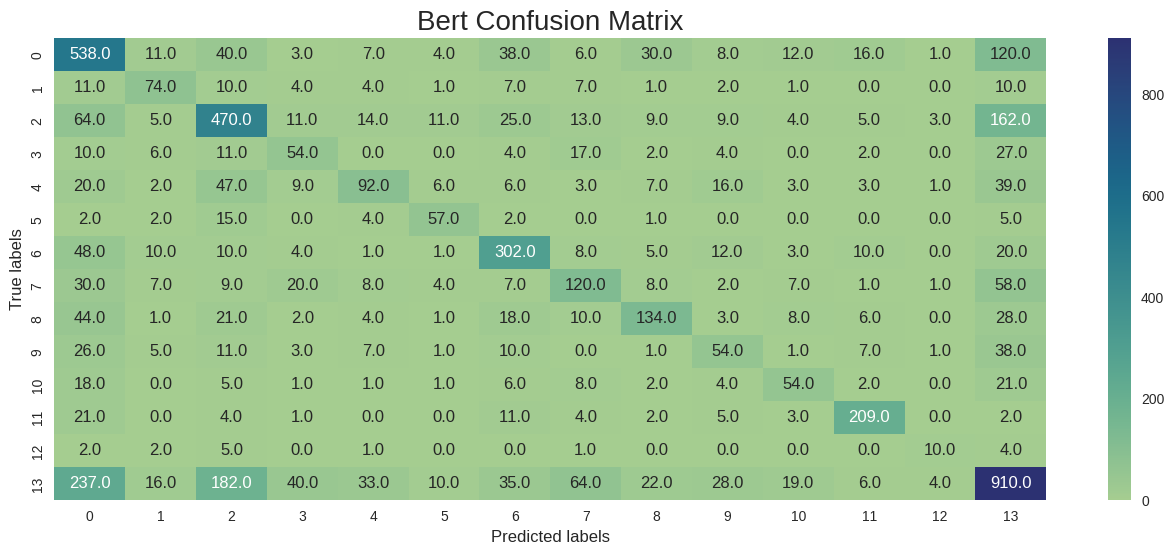

In [ ]:
plt.figure(figsize=(16, 6))
cm = confusion_matrix(np.asarray(berttargets).argmax(axis=1), np.asarray(bertoutputs).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='.1f', cmap='crest')

plt.xlabel("Predicted labels", size=12)
plt.ylabel("True labels", size=12)
plt.title("Bert Confusion Matrix", size=20)
plt.show()

In [ ]:
print("learning rate:",lr,"Batch size:",batch_size,"Loss function:",loss_fn)
for epoch in range(10):
  train(robertamodel,epoch,robertatrain_dataloader,robertaoptimizer)

learning rate: 2e-05 Batch size: 64 Loss function: BCEWithLogitsLoss()
Train ===> Epoch : 0 Loss: 0.18720409274101257
Train ===> Epoch : 1 Loss: 0.18155473470687866
Train ===> Epoch : 2 Loss: 0.15376484394073486
Train ===> Epoch : 3 Loss: 0.10697807371616364
Train ===> Epoch : 4 Loss: 0.08182181417942047
Train ===> Epoch : 5 Loss: 0.055012110620737076
Train ===> Epoch : 6 Loss: 0.16957780718803406
Train ===> Epoch : 7 Loss: 0.0729747861623764
Train ===> Epoch : 8 Loss: 0.007514128927141428
Train ===> Epoch : 9 Loss: 0.05741863697767258


In [ ]:
robertaoutputs, robertatargets = test(robertamodel,robertatest_dataloader)
robertaoutputs = np.array(robertaoutputs) >= 0.5
robertaacc = metrics.accuracy_score(robertatargets, robertaoutputs)
print("Accuracy:",(robertaacc)*100)

Accuracy: 49.97236042012162


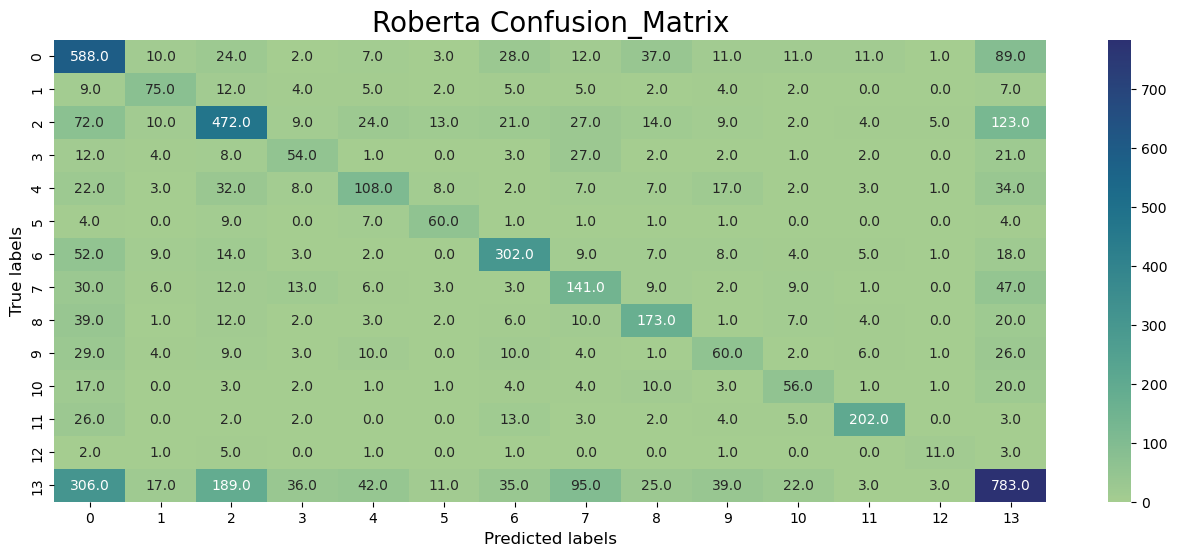

In [ ]:
plt.figure(figsize=(16, 6))
cm = confusion_matrix(np.asarray(robertatargets).argmax(axis=1), np.asarray(robertaoutputs).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='.1f', cmap='crest')

plt.xlabel("Predicted labels", size=12)
plt.ylabel("True labels", size=12)
plt.title("Roberta Confusion Matrix", size=20)
plt.show()

In [ ]:
test_text= "Just rumors online, it most likely won't happen"
test_encoding=(robertatokenizer.encode_plus(test_text,max_length=30,truncation=True,return_token_type_ids=True,padding='max_length',return_tensors='pt')).to(device)
test_prediction = robertamodel(test_encoding["input_ids"], test_encoding["attention_mask"],test_encoding['token_type_ids'])
copy=test_prediction.cpu().flatten().detach().numpy()
for label, prediction in zip(newlabelnames, copy):
    if prediction.any() < 0.5:
        continue
    print(f"{label} : ","{:.2f}".format(prediction))

appreciation :  -6.10
surprise :  -4.43
negative :  2.54
confusion :  -5.53
sadness :  -2.58
fear :  -5.23
happy :  -5.06
desire :  -5.22
affection :  -6.31
distress :  -2.56
confidence :  0.95
gratitude :  -4.80
embarrassment :  -4.33
neutral :  -5.49


In [ ]:
test_text= "I just came home, what the fuck is this lineup? I love you [NAME] you mad bastard !!"
test_encoding=(robertatokenizer.encode_plus(test_text,max_length=30,truncation=True,return_token_type_ids=True,padding='max_length',return_tensors='pt')).to(device)
test_prediction = robertamodel(test_encoding["input_ids"], test_encoding["attention_mask"],test_encoding['token_type_ids'])
copy=test_prediction.cpu().flatten().detach().numpy()
for label, prediction in zip(newlabelnames, copy):
    if prediction.any() < 0.5:
        continue
    print(f"{label} : ","{:.2f}".format(prediction))

appreciation :  -4.59
surprise :  -3.70
negative :  1.70
confusion :  -3.95
sadness :  -4.51
fear :  -4.63
happy :  -3.52
desire :  -3.06
affection :  3.45
distress :  -5.06
confidence :  -5.54
gratitude :  -5.13
embarrassment :  -5.70
neutral :  -6.31


In [ ]:
# torch.save(robertamodel.state_dict(),'emotions_roberta_model1.pt')
# torch.save(bertmodel.state_dict(),'emotions_bert_model1.pt')